In [1]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
#export format CoCo 
# open json file
path = "D:/Project2022/res/Datasets/mask_data_covid/parse.json"

with open(path, ) as file:
    mask_data = json.load(file)

# Json structure

In [3]:
mask_data[0]["data"]["image"][14:]


'/47c54299-P104_98.png'

In [4]:
mask_data[0]["annotations"][0]["result"]

[{'original_width': 512,
  'original_height': 512,
  'image_rotation': 0,
  'value': {'x': 14.84374999999998,
   'y': 26.95312499999996,
   'width': 66.99218749999996,
   'height': 45.31249999999997,
   'rotation': 0,
   'rectanglelabels': ['Open lungs']},
  'id': 'VMZnXhZ4-0',
  'from_name': 'label',
  'to_name': 'image',
  'type': 'rectanglelabels',
  'origin': 'manual'}]

In [5]:
# returns an image and bb coordinates
def getBbox(img_array, x, y, width, height):
    coordinates = []
    
    #print(img)
    #img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    #img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
    #print(img_array.shape)
    #bbox co ordinated -----> x1,y1   x2,y2
    #print(annatation["bbox"])
    #plt.imshow(img_array, cmap="gray")

    row = img_array.sum(axis=0)
    coloumn = img_array.sum(axis=1)

    #concat rows and coloumn
    concat_data = np.concatenate((row, coloumn))

    x1 = x/100*512
    y1 = y/100*512

    x2_temp = width/100*512
    y2_temp = height/100*512

    x2 = x1+x2_temp
    y2 = y1+y2_temp

    
    '''mid_x = (x1+x2)/2
    mid_y = (y1+y2)/2
    x1 = mid_x - (med_width/2)
    y1 = mid_y - (med_height/2)

    x2 = mid_x + (med_width/2) 
    y2 = mid_y + (med_height/2)'''
    
    coordinates.append(int(x1))
    coordinates.append(int(y1))
    coordinates.append(int(x2))
    coordinates.append(int(y2))
    return concat_data, row, coloumn, coordinates


1004

## Find the medians for the bbox

In [7]:
median_width = []
median_height = []
for data in tqdm(mask_data):
    if(len(data["annotations"][0]["result"]) != 0):

        x = data["annotations"][0]["result"][0]["value"]["x"]
        y = data["annotations"][0]["result"][0]["value"]["y"]
        
        width = data["annotations"][0]["result"][0]["value"]["width"]
        height = data["annotations"][0]["result"][0]["value"]["height"]

        x1 = x/100*512
        y1 = y/100*512
        x2_temp = width/100*512
        y2_temp = height/100*512

        x2 = x1+x2_temp
        y2 = y1+y2_temp


        median_width.append(x2-x1)
        median_height.append(y2-y1)


med_width = np.median(median_width)
med_height = np.median(median_height)




print("median_width:", med_width)
print("median_height:", med_height)



median_width: 361.00000000000017
median_height: 269.9999999999999


## Fetch Dataset 

In [17]:
path = "D:/Project2022/res/Datasets/mask_data_covid/images/"

raw_images= []
conacat_image = []
row_sum = []
coloumn_sum = []
bb_cordinates = []

for data in tqdm(mask_data):
#for data, bb_data in zip(mask_data["image"], mask_data["label"]):
    #print(data["annotations"][0]["result"][0]["value"])

    if(len(data["annotations"][0]["result"]) != 0):
        x = data["annotations"][0]["result"][0]["value"]["x"]
        y = data["annotations"][0]["result"][0]["value"]["y"]
        width = data["annotations"][0]["result"][0]["value"]["width"]
        height = data["annotations"][0]["result"][0]["value"]["height"]

    

        #print(data["data"]["image"][15:])
        img = data["data"]["image"][15:]

    
        if(os.path.isfile(os.path.join(path,img))):

            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            #plt.imshow(img_array, cmap="gist_gray")
            #plt.show()
            img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)

            data, rowSum, coloumnSum, label = getBbox(img_array, x, y, width, height)
            #data, label = getBbox(img_array, x, y, med_width, med_height)

            raw_images.append(img_array)
            conacat_image.append(data)
            row_sum.append(rowSum)
            coloumn_sum.append(coloumnSum)
            bb_cordinates.append(label)

            plot_array = np.copy(img_array)
            cv2.rectangle(plot_array, (label[0], label[1]), (label[2], label[3]),color=(255, 0, 0), thickness=2)
            cv2.imwrite("D:/Project2022/res/Datasets/mask_data_covid/output1/"+img, plot_array)



            # Flip the ct scan (axis = 1 ) and its Bbox
            img_flip = np.copy(img_array)
            img_flip = cv2.flip(img_flip, 1)

            data, rowSum, coloumnSum, label = getBbox(img_flip, x, y, width, height)
            #data, label = getBbox(img_flip, x, y, med_width, med_height)

            #plt.figure(figsize=(5, 5), dpi=100)
            
            bbox_flip = [512-label[2], label[1], 512-label[0], label[3]]

            raw_images.append(img_flip)
            conacat_image.append(data)
            row_sum.append(rowSum)
            coloumn_sum.append(coloumnSum)
            bb_cordinates.append(bbox_flip)

            plot_array = np.copy(img_flip)
            cv2.rectangle(plot_array, (bbox_flip[0], bbox_flip[1]), (bbox_flip[2], bbox_flip[3]),color=(255, 0, 0), thickness=2)
            cv2.imwrite("D:/Project2022/res/Datasets/mask_data_covid/output1/"+"flip_"+img, plot_array)

                #plt.imshow(img_array)

                #print(data.shape)
                #print(label)'''

    
    

  0%|          | 0/1004 [00:00<?, ?it/s]

In [21]:
mask_df = pd.DataFrame()
mask_df["raw data"] = raw_images
mask_df["concat data"] = conacat_image
mask_df["row_sum"] = row_sum
mask_df["coloumn_sum"] = coloumn_sum
mask_df["bbox"] = bb_cordinates

In [22]:
print("No of samles:", mask_df.shape[0])

No of samles: 1870


In [23]:
mask_df.head()


,raw data,concat data,row_sum,coloumn_sum,bbox
0,"[[2, 3, 2, 0, 2, 4, 1, 1, 2, 5, 4, 0, 0, 4, 3,...","[18381, 18619, 18847, 19111, 19284, 19356, 194...","[18381, 18619, 18847, 19111, 19284, 19356, 194...","[1087, 1105, 1093, 1080, 1060, 1078, 1122, 111...","[75, 137, 418, 369]"
1,"[[0, 0, 0, 0, 0, 0, 0, 2, 4, 3, 1, 1, 2, 4, 3,...","[10820, 11123, 11498, 11846, 12171, 12608, 131...","[10820, 11123, 11498, 11846, 12171, 12608, 131...","[1087, 1105, 1093, 1080, 1060, 1078, 1122, 111...","[94, 137, 437, 369]"
2,"[[2, 2, 0, 0, 2, 3, 3, 1, 1, 3, 5, 3, 3, 1, 0,...","[18420, 18699, 18940, 19216, 19474, 19567, 196...","[18420, 18699, 18940, 19216, 19474, 19567, 196...","[1100, 1111, 1115, 1079, 1086, 1091, 1091, 111...","[75, 139, 419, 372]"
3,"[[0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 3, 4, 2, 1, 2,...","[10764, 11061, 11419, 11766, 12157, 12639, 132...","[10764, 11061, 11419, 11766, 12157, 12639, 132...","[1100, 1111, 1115, 1079, 1086, 1091, 1091, 111...","[93, 139, 437, 372]"
4,"[[0, 5, 6, 2, 0, 2, 5, 4, 0, 0, 4, 3, 0, 4, 5,...","[18244, 18490, 18691, 18850, 18979, 19150, 193...","[18244, 18490, 18691, 18850, 18979, 19150, 193...","[1074, 1077, 1075, 1067, 1049, 1045, 1063, 107...","[77, 140, 417, 368]"


In [40]:
#save data
mask_df.to_pickle("D:/Project2022/res/Datasets/mask_bbox_large_dataset.pickle")

In [27]:
#-----------------    0                1
#combine_X -----> [["raw data"], ["concat data"]]
combine_df = pd.DataFrame()
combine_df["raw data"] = raw_images
combine_df["concat data"] = conacat_image
combine_df["row_sum"] = row_sum
combine_df["coloumn_sum"] = coloumn_sum

In [37]:
# Dataset shape
print("X shape:", np.array(conacat_image).shape )
print("row sum shape", np.array(row_sum).shape)
print("coloumn sum shape", np.array(coloumn_sum).shape)
print("y shape:", np.array(bb_cordinates).shape)

X shape: (1870, 1024)
row sum shape (1870, 512)
coloumn sum shape (1870, 512)
y shape: (1870, 4)


In [43]:
def data_reshape(array):
    data = []
    for sample in tqdm(array):
        data.append(list(sample))
    return np.array(data)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(combine_df, bb_cordinates, test_size = 0.2, random_state = 42)
#X_train, X_test, y_train, y_test = train_test_split(conacat_image, bb_cordinates, test_size = 0.2, random_state = 42)

In [44]:
#normalize the train data
from sklearn import preprocessing
# Training data
norm_x = preprocessing.normalize(data_reshape(X_train["concat data"]))
norm_x1 = preprocessing.normalize(data_reshape(X_train["row_sum"]))
norm_x2 = preprocessing.normalize(data_reshape(X_train["coloumn_sum"]))

norm_y = np.array(y_train)/512
# Testing data
norm_x_test = preprocessing.normalize(data_reshape(X_test["concat data"]))
norm_x1_test = preprocessing.normalize(data_reshape(X_test["row_sum"]))
norm_x2_test = preprocessing.normalize(data_reshape(X_test["coloumn_sum"]))


norm_y_test = np.array(y_test)/512


  0%|          | 0/1496 [00:00<?, ?it/s]

  0%|          | 0/1496 [00:00<?, ?it/s]

  0%|          | 0/1496 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

In [49]:
input_global = Input(shape=(1024,))
input_rowSum = Input(shape=(512,))
input_coloumnSum = Input(shape=(512,))

x = Dense(256, activation="relu")(input_global)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Model(inputs=input_global, outputs=x)

x1 = Dense(512, activation="relu")(input_rowSum)
x1 = Dense(256, activation="relu")(x1)
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(64, activation="relu")(x1)
x1 = Model(inputs=input_rowSum, outputs=x1)

x2 = Dense(512, activation="relu")(input_coloumnSum)
x2 = Dense(256, activation="relu")(x2)
x2 = Dense(128, activation="relu")(x2)
x2 = Dense(64, activation="relu")(x2)
x2 = Model(inputs=input_coloumnSum, outputs=x2)

# combine the output of the three branches
combined = concatenate([x.output, x1.output, x2.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(100, activation="relu")(combined)
z = Dense(4, activation="linear")(z)

model = Model(inputs=[x.input, x1.input, x2.input], outputs=z)
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 dense_69 (Dense)               (None, 512)          262656      ['input_17[0][0]']               
                                                                                           

In [50]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model.fit([norm_x, norm_x1, norm_x2], norm_y, epochs=100)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
47/47 [==============================] - 2s 17ms/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2/100
47/47 [==============================] - 1s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 3/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 4/100
47/47 [=============================

In [3]:
# Define model
model = Sequential()
model.add(Dense(512, input_dim=1024, activation= "relu"))
model.add(Dense(256, activation= "relu"))
model.add(Dense(128, activation= "relu"))
model.add(Dense(64, activation= "relu"))
model.add(Dense(4))
model.summary() # Print model Summary

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 260       
Total params: 697,540
Trainable params: 697,540
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model.fit(norm_x, norm_y, epochs=15)

Epoch 1/15
47/47 [==============================] - 0s 4ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 2/15
47/47 [==============================] - 0s 4ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 3/15
47/47 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 4/15
47/47 [==============================] - 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 5/15
47/47 [==============================] - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 6/15
47/47 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 7/15
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 8/15
47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 9/15
47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 10/15
47/47 [=========

In [55]:
model.save("D:/Project2022/Code/bbox_estimator_3Inputs.h5")

In [2]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [2]:
import keras
model_name = "bbox_estimator_3Inputs"
model = keras.models.load_model("D:/Project2022/Code/"+model_name+".h5")

In [3]:
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 dense_69 (Dense)               (None, 512)          262656      ['input_17[0][0]']               
                                                                                           

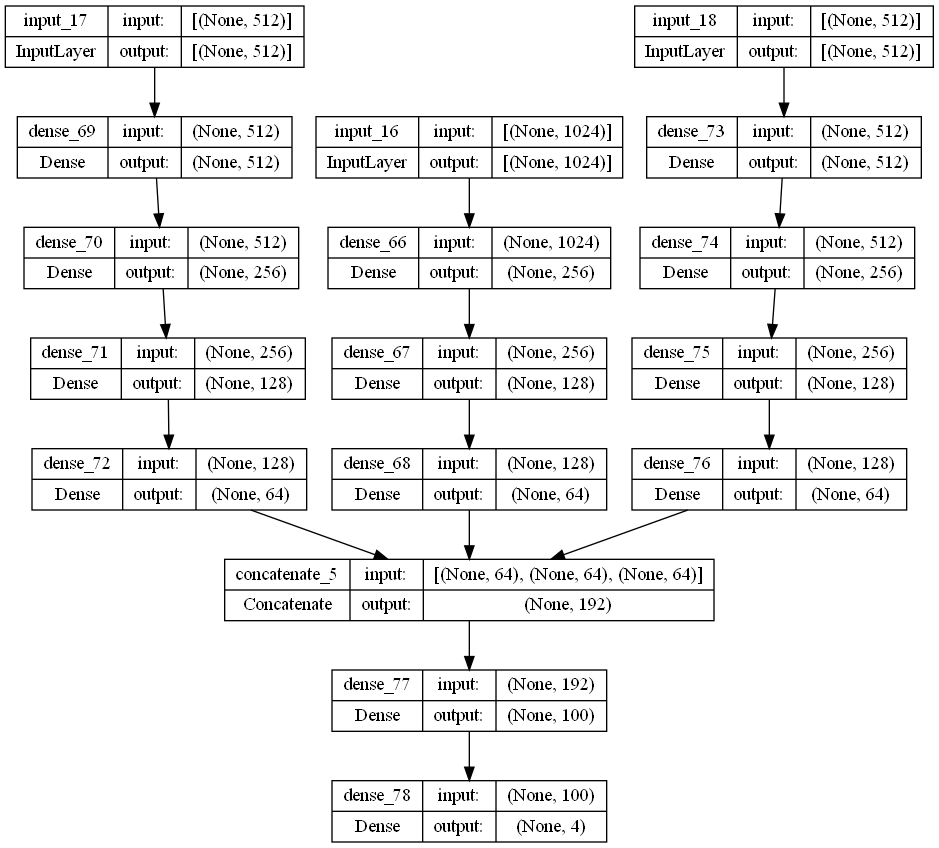

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [51]:
pred = model.predict([norm_x_test, norm_x1_test, norm_x2_test])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
12/12 [==============================] - 0s 6ms/step


In [52]:
# de normalize the coordinates
y_actual = np.array(y_test)
y_pred = pred*512

In [53]:
print("No of test samples:", len(y_pred))

No of test samples: 374


## plot the predicted co-ordinates on the test data

In [54]:
#path = "D:/Project2022/res/Datasets/mask/test_3inputs"
test_samples = data_reshape(X_test["raw data"])
no = 1
for img_array, tcoor, coor  in zip(test_samples, y_actual, y_pred):
    file = "sample"+str(no)+".png"
    #plt.imshow(img_array, cmap="gray")
    #plt.show()
    #print(coor)

    cv2.putText(img_array, 'true', (int(tcoor[0]), int(tcoor[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    cv2.rectangle(img_array, 
        (int(tcoor[0]), int(tcoor[1])), 
        (int(tcoor[2]), int(tcoor[3])),
        color=(36, 255, 12), 
        thickness=3)

    
    cv2.putText(img_array, 'pred', (int(coor[0]), int(coor[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 1)
    cv2.rectangle(img_array, 
        (int(coor[0]), int(coor[1])), 
        (int(coor[2]), int(coor[3])),
        color=(255, 0, 0), 
        thickness=1)
    

    cv2.imwrite("D:/Project2022/Code/mask_keras/"+file,img_array)
    no += 1
    

  0%|          | 0/374 [00:00<?, ?it/s]

# Testing on large dataset

In [6]:
# Load the model
from keras.models import load_model
model = load_model('D:/Project2022/Code/bbox_estimator.h5')

In [56]:
# returns an image and bb coordinates
def img_to_arr(img_array ):
    coordinates = []
    row = img_array.sum(axis=0)
    coloumn = img_array.sum(axis=1)

    #concat rows and coloumn
    concat_data = np.concatenate((row, coloumn))

    return concat_data, row, coloumn

In [57]:
dataset_path = "D:/Project2022/res/final dataset/original/normal"
raw_data = []
concat_data =[]
row_sum = []
coloumn_sum = []

for img in tqdm(os.listdir(dataset_path)):
    #print(img)

    img_array = cv2.imread(os.path.join(dataset_path,img), cv2.IMREAD_GRAYSCALE)
    img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)

    data, row, coloumn  = img_to_arr(img_array)
    #data, label = getBbox(img_array, x, y, med_width, med_height)

    raw_data.append(img_array)
    concat_data.append(data)
    row_sum.append(row)
    coloumn_sum.append(coloumn)
    

  0%|          | 0/6893 [00:00<?, ?it/s]

In [58]:
#normalize the train data
from sklearn import preprocessing
x_large = preprocessing.normalize(data_reshape(concat_data))
x1_large = preprocessing.normalize(data_reshape(row_sum))
x2_large = preprocessing.normalize(data_reshape(coloumn_sum))


  0%|          | 0/6893 [00:00<?, ?it/s]

  0%|          | 0/6893 [00:00<?, ?it/s]

  0%|          | 0/6893 [00:00<?, ?it/s]

In [59]:
pred_bbox_large = model.predict([x_large, x1_large, x2_large])

#de-normalize
pred_bbox_large = pred_bbox_large*512

216/216 [==============================] - 1s 5ms/step


In [60]:
print("BBox shape:",pred_bbox_large.shape)


BBox shape: (6893, 4)


# plot un-scaled predicted bboxes

In [61]:
samples = data_reshape(raw_data)
no = 1
for img_array, coor  in tqdm(zip(samples, pred_bbox_large), total = len(raw_data)):
    file = "sample"+str(no)+".png"
    #plt.imshow(img_array, cmap="gray")
    #plt.show()
    #print(coor)
    
    cv2.putText(img_array, 'pred', (int(coor[0]), int(coor[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 1)
    cv2.rectangle(img_array, 
        (int(coor[0]), int(coor[1])), 
        (int(coor[2]), int(coor[3])),
        color=(255, 0, 0), 
        thickness=1)
    

    cv2.imwrite("D:/Project2022/Code/predicted_bbox/unscaled/"+file,img_array)
    no += 1

  0%|          | 0/6893 [00:00<?, ?it/s]

  0%|          | 0/6893 [00:00<?, ?it/s]

# find the median bbox

In [62]:
median_width = []
median_height = []
for bbox in tqdm(pred_bbox_large):
    median_width.append(bbox[2] - bbox[0])
    median_height.append(bbox[3] - bbox[1])


med_width = np.median(median_width)
med_height = np.median(median_height)


print("median_width:", med_width)
print("median_height:", med_height)
    



  0%|          | 0/6893 [00:00<?, ?it/s]

median_width: 375.13644
median_height: 274.2811


In [63]:


def scale_bbox(pred_bbox):

    coordinates = []
    mid_x = (pred_bbox[0]+pred_bbox[2])/2
    mid_y = (pred_bbox[1]+pred_bbox[3])/2

    width = pred_bbox[2] - pred_bbox[0]
    height = pred_bbox[3] - pred_bbox[1]

    #print("med_width", med_width)
    #print("med_height", med_height)

    #print("width",width)
    #print("height",height)
    #width_diff = med_width - width
    #height_diff = med_height - height

    vert_scale = width/med_width
    horzi_scale = height/med_height

    #vert_scale = med_width/width
    #horzi_scale = med_height/height

    scale_factor = max(vert_scale,horzi_scale)


    #print("width_diff",vert_scale)
    #print("height_diff",horzi_scale)

    #scale_factor = width_diff / height_diff
    

    #print("scale_factor",scale_factor)

    scaled_width = med_width * scale_factor
    scaled_height = med_height * scale_factor

    #print("scaled_width", scaled_width)
    #print("scaled_height", scaled_height)


    x1 = mid_x - (scaled_width/2)
    y1 = mid_y - (scaled_height/2)

    x2 = mid_x + (scaled_width/2) 
    y2 = mid_y + (scaled_height/2)


    if(x1<0):
        x1 = 0
    
    if(y1<0):
        y1 = 0

    if(x2>512):
        x2 = 512

    if(y2>512):
        y2 = 512

    coordinates.append(x1)
    coordinates.append(y1)
    coordinates.append(x2)
    coordinates.append(y2)
    return coordinates



# plot scaled predicted bboxes

In [64]:
samples = data_reshape(raw_data)
no = 1
for img_array, pred_bbox  in tqdm(zip(samples, pred_bbox_large), total = len(raw_data)):
    file = "sample"+str(no)+".png"
    #plt.imshow(img_array, cmap="gray")
    #plt.show()
    #print(coor)


    cv2.putText(img_array, 'predicted', (int(pred_bbox[2]-100), int(pred_bbox[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
    cv2.rectangle(img_array, 
        (int(pred_bbox[0]), int(pred_bbox[1])), 
        (int(pred_bbox[2]), int(pred_bbox[3])),
        color=(255, 0, 0), 
        thickness=2)


    coor = scale_bbox(pred_bbox)
    
    cv2.putText(img_array, 'Scaled', (int(coor[0]), int(coor[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 1)
    cv2.rectangle(img_array, 
        (int(coor[0]), int(coor[1])), 
        (int(coor[2]), int(coor[3])),
        color=(255, 0, 0), 
        thickness=1)
    

    cv2.imwrite("D:/Project2022/Code/predicted_bbox/scaled/"+file,img_array)
    no += 1

  0%|          | 0/6893 [00:00<?, ?it/s]

  0%|          | 0/6893 [00:00<?, ?it/s]

In [12]:
samples = data_reshape(raw_data)

## crop images w.r.t predicted BBox

In [28]:
scaledBbox = [] 
no = 1
for img_array, pred_bbox in tqdm(zip(samples, pred_bbox_large), total=(len(samples))):
    file = "sample_normal"+str(no)+".png"
    
    #predicted bbox
    #bbox = [int(pred_bbox[0]), int(pred_bbox[1]), int(pred_bbox[2]), int(pred_bbox[3])]

    #scaled bbox
    coor = scale_bbox(pred_bbox)
    bbox = [int(coor[0]), int(coor[1]), int(coor[2]), int(coor[3])]
    #scaledBbox.append(bbox)

    #plt.figure(figsize=(8, 6), dpi=80)
    '''cv2.rectangle(img_array, 
        (bbox[0], bbox[1]), 
        (bbox[2], bbox[3]),
        color=(255, 0, 0), 
        thickness=2)'''
    
    #[y1,y2    x1,x2]
    cropped_image = img_array[ bbox[1]:bbox[3], bbox[0]:bbox[2]]

    cv2.imwrite("D:/Project2022/res/final dataset/scaled/normal/"+file,cropped_image)
    no += 1

    #plt.imshow(cropped_image, cmap="gray")
    #print(bbox)
    
    

In [53]:
def find_median(pred_bbox_large):
    median_width = []
    median_height = []
    for bbox in tqdm(pred_bbox_large):
        median_width.append(bbox[2] - bbox[0])
        median_height.append(bbox[3] - bbox[1])


    med_width = int(np.median(median_width))
    med_height = int(np.median(median_height))
    return med_width, med_height




In [22]:
width_resize =  int(367)
height_resize = int(252)

In [54]:
width_resize, height_resize = find_median(scaledBbox)
print("scaled median_width:", width_resize)
print("scaled median_height:", height_resize)


scaled median_width: 367
scaled median_height: 252


### Resize the scaled images to a median width and height

In [26]:
dim = (width_resize, height_resize)
no = 1
for img_array, pred_bbox in tqdm(zip(samples, pred_bbox_large), total=(len(samples))):
    file = "sample_normal_"+str(no)+".png"


    #scaled bbox
    coor = scale_bbox(pred_bbox)
    bbox = [int(coor[0]), int(coor[1]), int(coor[2]), int(coor[3])]


    #plt.figure(figsize=(8, 6), dpi=80)
    '''cv2.rectangle(img_array, 
        (bbox[0], bbox[1]), 
        (bbox[2], bbox[3]),
        color=(255, 0, 0), 
        thickness=2)'''
    
    #[y1,y2    x1,x2]
    cropped_image = img_array[ bbox[1]:bbox[3], bbox[0]:bbox[2]]

    resized_cropped_image = cv2.resize(cropped_image, dim, interpolation= cv2.INTER_LINEAR)



    cv2.imwrite("D:/Project2022/res/final dataset/scaled_resized/normal/"+file,resized_cropped_image)
    no += 1

    #plt.imshow(resized_cropped_image, cmap="gray")
    #print(bbox)
    
    
    

